# Names 
Spencer Bernardo-Cheng
Max Goldstein
Robbie Keehan

# Data Preparation

In [8]:
import numpy as np
import pandas as pd
datafb = pd.read_csv("./FB.csv")
datagoogle = pd.read_csv("./GOOGL.csv")
datamsft = pd.read_csv("./MSFT.csv")
dataam = pd.read_csv("./AMZN (1).csv")
datanflx = pd.read_csv("./NFLX.csv")

del datafb['Date']
del datagoogle['Date']
del datamsft['Date']
del datanflx['Date']


data = pd.concat([datafb, datagoogle, datamsft,datanflx, dataam ], axis=1, sort=False)
data = data[89:]
del data['Change']
del data['Gain']
del data['Loss']
del data['Average Gain']
del data['Average Loss']
del data['RS']
del data['DM+1']
del data['DM-1']
del data['TR-14']
del data['DM+1-14']
del data['DM-1+14']
del data['dl+1-14']
del data['dl-1-14']
del data['dl14diff']
del data['dl14sum']
del data['DX']
del data['TR']
ogdates = []
for val in data['Date']:
    ogdates.append(val)
del data['Date']

predictedDays = 14
up = .03
down =-.03
## Time difference the data
colheaders = data.columns[0:-3]
og = []
for val in data['Close-amzn']:
    og.append(val)
for header in colheaders: 
    for i in range(1, len(data)):
        perchange =((data[header].iloc[i]) - (data[header].iloc[i - 1]))/float(data[header].iloc[i-1])
        data.set_value(89+i,"pc-"+header,perchange)
#         data["pc"+header].at[90+i]= perchange
data = data[1:]
ydata = data['pc-Close-amzn']
# ydata = ydata.apply(lambda x:2 if x>=up else (1 if (x< up and x > down) else 0))
ydata = pd.DataFrame(ydata)
ydata['newy'] = ""
# created target data in format to match output of multiple timesteps of 14 days ahead
# [0,1,2,3,4,5,6,7]
# [1,2,3,4,5,6,7,8]
for index, row in ydata.iterrows():
    temp = np.array(ydata['pc-Close-amzn'][index-90:index-90+predictedDays].values)
    ydata['newy'].at[index] = temp
    
# removed last 14 because their targets are not able to created
ydata = ydata[0:-(predictedDays-1)]
data = data[0:-(predictedDays-1)]

del ydata['pc-Close-amzn']

xdata =data[['RSI-14 Day', 'ADX',
       'pc-Open-fb', 'pc-High-fb', 'pc-Low-fb', 'pc-Close-fb',
       'pc-Adj Close-fb', 'pc-Volume-fb', 'pc-Open-googl', 'pc-High-googl',
       'pc-Low-googl', 'pc-Close-googl', 'pc-Adj Close-googl',
       'pc-Volume-googl', 'pc-Open-msft', 'pc-High-msft', 'pc-Low-msft',
       'pc-Close-msft', 'pc-Adj Close-msft', 'pc-Volume-msft', 'pc-Open-nflx',
       'pc-High-nflx', 'pc-Low-nflx', 'pc-Close-nflx', 'pc-Adj Close-nflx',
       'pc-Volume-nflx', 'pc-Open-amzn', 'pc-High-amzn', 'pc-Low-amzn',
       'pc-Close-amzn', 'pc-Adj Close-amzn', 'pc-Volume-amzn', 'pc-SMA-7',
       'pc-SMA-21', 'pc-SMA-90']]


data = data[0:-1]
xdata = xdata[0:-1]
ydata = ydata[0:-1]
# data = data.T


//anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


# One Hot Encoding The Target Data

In [9]:
from keras.utils.np_utils import to_categorical
print(ydata.head())
# ydata['newy'] = ydata['newy'].apply(lambda x: to_categorical(x,3))
print(ydata)

                                                 newy
90  [-0.03126685348001901, -0.023788658883803833, ...
91  [-0.023788658883803833, -0.0031430016910281716...
92  [-0.0031430016910281716, -0.007616083827630422...
93  [-0.007616083827630422, 0.00750945697512207, -...
94  [0.00750945697512207, -0.0009828446509949397, ...
                                                   newy
90    [-0.03126685348001901, -0.023788658883803833, ...
91    [-0.023788658883803833, -0.0031430016910281716...
92    [-0.0031430016910281716, -0.007616083827630422...
93    [-0.007616083827630422, 0.00750945697512207, -...
94    [0.00750945697512207, -0.0009828446509949397, ...
...                                                 ...
1873  [-0.007968049902658595, 0.0035842157954330814,...
1874  [0.0035842157954330814, -0.01399888357705284, ...
1875  [-0.01399888357705284, 0.000849913019005562, -...
1876  [0.000849913019005562, -0.008611641517542337, ...
1877  [-0.008611641517542337, 0.007496472572400493, ...

[17

# Min-Max Scaling the Time Series

In [10]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(xdata.iloc[:,:].values)
print(x_scaled)



[[0.35811382 0.15022488 0.40722014 ... 0.53721892 0.45230866 0.64160589]
 [0.26414926 0.12331708 0.35961381 ... 0.50635447 0.41867806 0.57327146]
 [0.25300192 0.10448737 0.40286589 ... 0.51153038 0.41312322 0.576277  ]
 ...
 [0.3029723  0.1344608  0.461637   ... 0.50352112 0.48231708 0.23750753]
 [0.31038595 0.1153046  0.38866776 ... 0.50862139 0.47320208 0.21748327]
 [0.25243424 0.13533161 0.42314792 ... 0.49730187 0.44639693 0.21806241]]


# Utilizing Time Series Generator

In [72]:
from keras.models import Sequential
from keras.layers import Dense
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM, Lambda, Dropout,GRU
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 2
series = np.array(x_scaled)
target = np.array(ydata)
generator = TimeseriesGenerator(series, target, length=90, batch_size=1)
xtime = []
ytarget =[]
for i in range(len(generator)):
    x, y = generator[i]
    xtime.append(x[0])
xtime = np.array(xtime)

target = target[90:]
newtarget = []
for val in target:
    newtarget.append(np.array(val[0]))
ytarget = np.array(newtarget)
print(ytarget.shape)


(1698, 14)


# Time Series Fold Splits

In [73]:
from sklearn.model_selection import train_test_split
import keras.utils
from keras import utils as np_utils
from sklearn.model_selection import TimeSeriesSplit
# for train_index, test_index in tscv.split(xtime,ytarget):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     x_train, x_test = xtime[train_index], xtime[test_index]
#     y_train, y_test = ytarget[train_index], ytarget[test_index]
    
    
    
x_train,x_test,y_train,y_test = train_test_split(xtime, ytarget, test_size = 1/4)



y_train = y_train.reshape(1273,14,1)
y_test= y_test.reshape(425,14,1)



# LSTM

In [35]:

model = Sequential()
model.add(LSTM(100,dropout=.2,activation='relu', input_shape=(90, 35), return_sequences=True))
model.add(Lambda(lambda x: x[:, -predictedDays:, :]))
model.add(Dense(1))

model.summary()
model.compile(optimizer='adam', loss='mse')

# fit model
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=50, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 90, 100)           54400     
_________________________________________________________________
lambda_2 (Lambda)            (None, 14, 100)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 14, 1)             101       
Total params: 54,501
Trainable params: 54,501
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 1273 samples, validate on 425 samples
Epoch 1/50
1273/1273 [==============================] - 5s 4ms/step - loss: 0.0035 - val_loss: 3.7522e-04
Epoch 2/50
1273/1273 [==============================] - 4s 3ms/step - loss: 7.7170e-04 - val_loss: 3.5023e-04
Epoch 3/50
1273/1273 [==============================] - 4s 3ms/step - loss: 6.0301e-04 - va

# LSTM Validation & Training Loss

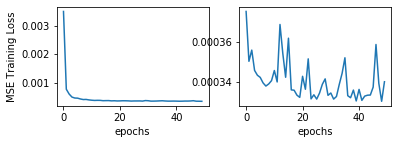

In [37]:
from matplotlib import pyplot as plt

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.show()

# GRU

In [71]:
from keras.layers import LSTM, Lambda, Dropout,GRU

gru = Sequential()
gru.add(GRU(100,dropout=.2,activation='relu', input_shape=(90, 35), return_sequences=True))
gru.add(Lambda(lambda x: x[:, -predictedDays:, :]))
gru.add(Dense(1))

gru.summary()
gru.compile(optimizer='adam', loss='mse')

# fit model
history = gru.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=600, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 90, 100)           40800     
_________________________________________________________________
lambda_8 (Lambda)            (None, 14, 100)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 14, 1)             101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Train on 1273 samples, validate on 425 samples
Epoch 1/600
1273/1273 [==============================] - 5s 4ms/step - loss: 0.0028 - val_loss: 5.0725e-04
Epoch 2/600
1273/1273 [==============================] - 3s 3ms/step - loss: 9.1358e-04 - val_loss: 4.3251e-04
Epoch 3/600
1273/1273 [==============================] - 3s 3ms/step - loss: 6.7628e-04 - val_loss: 7.5615e-04
Epoch 4/600
1273/1273 [===

1273/1273 [==============================] - 4s 3ms/step - loss: 3.2065e-04 - val_loss: 4.0491e-04
Epoch 68/600
1273/1273 [==============================] - 3s 3ms/step - loss: 3.3479e-04 - val_loss: 3.9036e-04
Epoch 69/600
1273/1273 [==============================] - 4s 3ms/step - loss: 3.2909e-04 - val_loss: 4.4764e-04
Epoch 70/600
1273/1273 [==============================] - 3s 3ms/step - loss: 3.2823e-04 - val_loss: 3.9463e-04
Epoch 71/600
1273/1273 [==============================] - 3s 3ms/step - loss: 3.2776e-04 - val_loss: 4.4026e-04
Epoch 72/600
1273/1273 [==============================] - 3s 3ms/step - loss: 3.4735e-04 - val_loss: 3.9743e-04
Epoch 73/600
1273/1273 [==============================] - 3s 3ms/step - loss: 3.3153e-04 - val_loss: 3.8625e-04
Epoch 74/600
1273/1273 [==============================] - 3s 3ms/step - loss: 3.5498e-04 - val_loss: 4.1404e-04
Epoch 75/600
1273/1273 [==============================] - 4s 3ms/step - loss: 3.4269e-04 - val_loss: 3.8717e-04
Epoch

KeyboardInterrupt: 

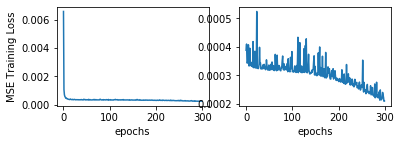

In [66]:
from matplotlib import pyplot as plt

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.show()

# Stacked RNN

In [42]:

modelstacked = Sequential()
modelstacked.add(GRU(100,dropout=.2,recurrent_dropout=.2,activation='relu', input_shape=(90, 35), return_sequences=True))
modelstacked.add(GRU(100,dropout=.4,activation='relu', return_sequences=True))

modelstacked.add(Lambda(lambda x: x[:, -predictedDays:, :]))

modelstacked.add(Dense(1))

modelstacked.summary()
modelstacked.compile(optimizer='adam', loss='mse')

# fit model
historystacked = modelstacked.fit(x_train, y_train, validation_data=(x_test,y_test),epochs=50, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 90, 100)           40800     
_________________________________________________________________
gru_6 (GRU)                  (None, 90, 100)           60300     
_________________________________________________________________
lambda_6 (Lambda)            (None, 14, 100)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 14, 1)             101       
Total params: 101,201
Trainable params: 101,201
Non-trainable params: 0
_________________________________________________________________
Train on 1273 samples, validate on 425 samples
Epoch 1/50
1273/1273 [==============================] - 8s 7ms/step - loss: 0.0016 - val_loss: 4.5502e-04
Epoch 2/50
1273/1273 [==============================] - 7s 5ms/step - loss: 5.2983e-04 - val_loss: 5.6828e-04
Epoch

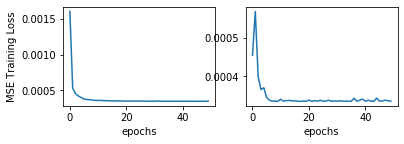

In [43]:
from matplotlib import pyplot as plt

plt.subplot(2,2,3)
plt.plot(historystacked.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(historystacked.history['val_loss'])
plt.xlabel('epochs')
plt.show()

# Backtracing GRU Prediction vs Real

[ 0.01731088 -0.00586697 -0.01240253 -0.00560598  0.01312064 -0.00343514
 -0.00364311  0.00880751  0.00253106 -0.0031608   0.00423388  0.01420993
  0.00665038 -0.00341239]
[-0.00638765  0.00177558 -0.00545572 -0.00672424 -0.01702     0.02691381
 -0.00293098 -0.02335222 -0.03194986  0.04031929 -0.03779899 -0.04383955
  0.01112177 -0.05206101]
[1603.069946, 1610.150024, 1612.869995, 1624.890015, 1629.619995, 1641.540039, 1665.27002, 1696.3499760000002, 1695.75, 1689.300049, 1683.9899899999998, 1689.119995, 1698.75, 1704.859985, 1723.859985, 1715.969971, 1723.790039, 1734.780029, 1750.0799559999998, 1730.219971, 1715.6700440000002, 1663.150024, 1691.089966, 1660.51001, 1701.449951, 1699.800049, 1713.780029, 1693.959961, 1699.72998, 1710.630005, 1739.02002, 1743.069946, 1755.0, 1796.619995, 1813.030029, 1822.4899899999998, 1843.930054, 1842.9200440000002, 1812.969971, 1813.699951, 1802.0, 1829.2399899999998, 1863.609985, 1808.0, 1817.27002, 1779.219971, 1777.439941, 1797.1700440000002, 183

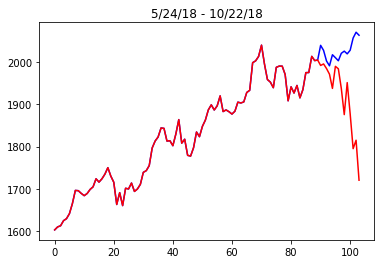

In [70]:
base = 1274
timeplus = 231
yhat = gru.predict(x_test[timeplus][np.newaxis,:,:])
print(yhat[0].ravel())
print(y_test[0].ravel())
print(og[base-90 + timeplus:base+14+timeplus])
# print(yhat[0] - y_test[0])
backtesting = og[base-90+timeplus:base+timeplus]
print(len(backtesting))
yhatBack=og[base-1+timeplus]
ytestBack = og[base-1+timeplus]
ytest_backtesting=og[base-90+timeplus:base+timeplus]

for i,val in enumerate(yhat[0].ravel()):
#     print(yhatBack)
    yhatBack = yhatBack * (1+val)
    
    backtesting.append(yhatBack)

for i,val in enumerate(y_test[0].ravel()):
#     print(ytestBack)
    ytestBack = ytestBack * (1+val)
    
    ytest_backtesting.append(ytestBack)
xbacktest= [x for x in range(0,104)]
plt.plot(xbacktest,backtesting,'b-')
plt.plot(xbacktest,ytest_backtesting,'r-')
plt.title("{} - {}".format(ogdates[base-90+timeplus],ogdates[base+14+timeplus]))

plt.show()


# Backtracing for LSTM and Real

[-3.6151544e-03 -8.4408093e-05 -6.1512599e-04 -1.3969173e-03
 -9.0010511e-04 -7.7431696e-04 -5.4881093e-03 -4.3464811e-03
  3.0382094e-03  1.6899570e-03  8.8692224e-04  3.7011686e-03
 -1.3563153e-03 -4.2728209e-03]
[-0.02198496  0.01740324  0.02177781 -0.00902921  0.0078602   0.00368596
  0.0057214   0.01333795  0.00333803  0.01444171 -0.00659631 -0.00915367
  0.02188399 -0.00841048]
[1003.73999, 993.9799800000001, 976.7800289999999, 990.330017, 975.929993, 968.0, 953.659973, 971.400024, 965.1400150000001, 978.76001, 996.4699710000001, 994.1300050000001, 1006.51001, 1000.6300050000001, 1001.8099980000001, 1010.0399779999999, 1024.449951, 1026.869995, 1028.699951, 1025.670044, 1038.949951, 1039.869995, 1052.800049, 1046.0, 1020.0399779999999, 987.7800289999999, 996.1900019999999, 995.8900150000001, 986.919983, 987.580017, 992.2700199999999, 989.840027, 982.01001, 956.919983, 967.98999, 983.2999880000001, 982.73999, 978.179993, 960.570007, 958.4699710000001, 953.2899779999999, 966.900024

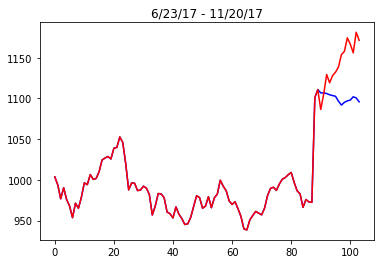

In [55]:
base = 1274
timeplus = 0
yhat = model.predict(x_test[timeplus][np.newaxis,:,:])
print(yhat[0].ravel())
print(y_test[0].ravel())
print(og[base-90 + timeplus:base+14+timeplus])
# print(yhat[0] - y_test[0])
backtesting = og[base-90+timeplus:base+timeplus]
yhatBack=og[base-1+timeplus]
ytestBack = og[base-1+timeplus]
ytest_backtesting=og[base-90+timeplus:base+timeplus]

for i,val in enumerate(yhat[0].ravel()):
#     print(yhatBack)
    yhatBack = yhatBack * (1+val)
    
    backtesting.append(yhatBack)

for i,val in enumerate(y_test[0].ravel()):
#     print(ytestBack)
    ytestBack = ytestBack * (1+val)
    
    ytest_backtesting.append(ytestBack)
xbacktest= [x for x in range(0,104)]
plt.plot(xbacktest,backtesting,'b-')
plt.plot(xbacktest,ytest_backtesting,'r-')
plt.title("{} - {}".format(ogdates[base-90+timeplus],ogdates[base+14+timeplus]))

plt.show()


# Backtracing for Stacked GRU and Real

[0.00077338 0.00071809 0.00078664 0.00066248 0.00106539 0.00136597
 0.00040065 0.00092256 0.00133777 0.00137912 0.00131445 0.00180455
 0.00157633 0.0011246 ]
[-0.02198496  0.01740324  0.02177781 -0.00902921  0.0078602   0.00368596
  0.0057214   0.01333795  0.00333803  0.01444171 -0.00659631 -0.00915367
  0.02188399 -0.00841048]
[1003.73999, 993.9799800000001, 976.7800289999999, 990.330017, 975.929993, 968.0, 953.659973, 971.400024, 965.1400150000001, 978.76001, 996.4699710000001, 994.1300050000001, 1006.51001, 1000.6300050000001, 1001.8099980000001, 1010.0399779999999, 1024.449951, 1026.869995, 1028.699951, 1025.670044, 1038.949951, 1039.869995, 1052.800049, 1046.0, 1020.0399779999999, 987.7800289999999, 996.1900019999999, 995.8900150000001, 986.919983, 987.580017, 992.2700199999999, 989.840027, 982.01001, 956.919983, 967.98999, 983.2999880000001, 982.73999, 978.179993, 960.570007, 958.4699710000001, 953.2899779999999, 966.900024, 958.0, 952.4500119999999, 945.26001, 946.0200199999999,

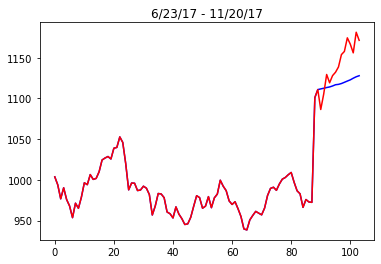

In [60]:
base = 1274
timeplus = 0
yhat = modelstacked.predict(x_test[timeplus][np.newaxis,:,:])
print(yhat[0].ravel())
print(y_test[0].ravel())
print(og[base-90 + timeplus:base+14+timeplus])
# print(yhat[0] - y_test[0])
backtesting = og[base-90+timeplus:base+timeplus]
yhatBack=og[base-1+timeplus]
ytestBack = og[base-1+timeplus]
ytest_backtesting=og[base-90+timeplus:base+timeplus]

for i,val in enumerate(yhat[0].ravel()):
#     print(yhatBack)
    yhatBack = yhatBack * (1+val)
    
    backtesting.append(yhatBack)

for i,val in enumerate(y_test[0].ravel()):
#     print(ytestBack)
    ytestBack = ytestBack * (1+val)
    
    ytest_backtesting.append(ytestBack)
xbacktest= [x for x in range(0,104)]
plt.plot(xbacktest,backtesting,'b-')
plt.plot(xbacktest,ytest_backtesting,'r-')
plt.title("{} - {}".format(ogdates[base-90+timeplus],ogdates[base+14+timeplus]))

plt.show()


In [ ]:
pred = model.predict(x_test[243][np.newaxis,:,:])
print(x_test[0].shape)
print(x_test.shape)

print(pred)
